In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import special, integrate
sys.path.insert(0, '/home/aew492/CFE_gradients/code')
import globals
globals.initialize_vals()
import generate_mock_list

## predicted variance in $\xi(r)$

The original equation given by Roman for the variance in the 2pcf at a certain length scale (neglecting shot noise):

$$
\Delta\xi^2(r) = \frac{(2\pi)^5}{V} \int \frac{k^2 dk}{kr} P^2(k) [J_{1/2}(kr)]^2
$$
where $V$ = survey volume, $\bar{n}$ is overall number density, and $J_{1/2}$ is a spherical Bessel function.

Roman uses the Fourier convention
$$
\xi(r) = \int d^3k\ e^{i \vec{k}\cdot\vec{r}} P(k)
$$
whereas based on simulation results it seems that we use the convention
$$
\xi(r) = \frac{1}{(2\pi)^3}\int d^3k\ e^{i\vec{k}\cdot\vec{r}}P(k)
$$

So if we define $P_{\mathrm{obs}}(k)\equiv P(k)+\frac{1}{\bar{n}}$ to account for shot noise,
and replace $P_{\mathrm{obs}}(k)\rightarrow \frac{1}{(2\pi)^3}P_{\mathrm{obs}}(k)$ to fix the Fourier convention,
then Roman's equation becomes
$$
\Delta\xi^2(r) = \frac{1}{2\pi V} \int_{k=.008}^{20} \frac{k^2 dk}{kr}\ \left[P(k)+\frac{1}{\bar{n}}\right]^2\ [J_{1/2}(kr)]^2
$$
where the integration bounds for $k$ are set on the lower end by $2\pi / L$, where $L$ is the survey edge length, and on the upper end by the resolution of the simulation (i.e. the highest $k$ used in the code).

**

The OLD modified version / with the different Fourier convention / with integration bounds is
$$
\Delta\xi^2(r) = \frac{1}{2\pi V} \int_{k=.008}^{20} \frac{k^2 dk}{kr}\ \left[P(k)+\frac{1}{2\pi\bar{n}}\right]^2\ [J_{1/2}(kr)]^2
$$

** We don't believe this form (can't see a justification for the $2\pi$ factor with $\bar{n}$).
However it seems like we have a justification for the change to the normalization factor:

### input power spectrum $P(k)$

In [3]:
# input power spectrum
Pk_fn='/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_pk.txt'
k, Pk = np.loadtxt(Pk_fn).T
# and galaxy power spectrum
PkG_fn='/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_pkG.dat'
kG, PkG = np.loadtxt(PkG_fn).T

In [4]:
# bias
b = 2

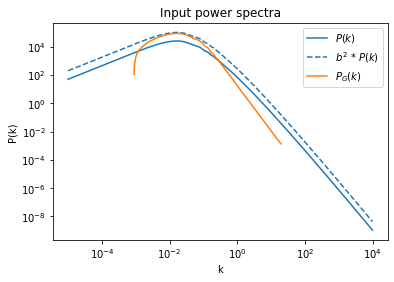

In [5]:
fig, ax = plt.subplots()
ax.plot(k, Pk, label='$P(k)$')
ax.plot(k, b**2 * Pk, color='C0', ls='--', label='$b^2$ * $P(k)$')
ax.plot(kG, PkG, label='$P_G(k)$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')
ax.set_title('Input power spectra')
ax.legend()

### check Fourier conventions: compute $\xi(r)$ from $P(k)$

Using convention
$$
\xi(r) = \frac{1}{(2\pi)^3} \int 4\pi k^2dk P(k)\frac{\sin(kr)}{kr}
$$

In [6]:
# catalog parameters
L = 750   # boxsize
b = 2     # bias
As = 2    # clustering amplitude
n = '2e-4'  # num. den. (although I don't think this has an impact here)

In [7]:
# k bounds
kmin = 2*np.pi/L
kmax = 20

imin = np.abs(k - kmin).argmin()
imax = np.abs(k - kmax).argmin()
print(k[imin], k[imax])

0.0084556074 19.827593


In [8]:
# r values: these to match the computations
nbins = 22
rmin = 20
rmax = 140
rs = np.linspace(rmin, rmax, nbins)

In [9]:
def P_interp(k_interp):
    return np.interp(k_interp, k, Pk)

In [10]:
def integrand_xi_func(k):
    return 4*np.pi * k**2 * (b**2 * P_interp(k)) * np.sin(k*r)/(k*r)

In [11]:
xi_arr = np.empty(rs.shape)
for i, r in enumerate(rs):
    integral_xi, _ = integrate.quad(integrand_xi_func, kmin, kmax, limit=500)
    xi = 1/(2*np.pi)**3 * integral_xi
    xi_arr[i] = xi

<ipython-input-11-3d2236658c66>:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_xi, _ = integrate.quad(integrand_xi_func, kmin, kmax, limit=500)


In [12]:
# load in the Landy-Szalay results
rlzs = 100
xi_lss = np.empty((rlzs, nbins))
for i in range(rlzs):
    r_avg, xi_ls = np.load(os.path.join(globals.data_dir, f'lognormal/L{L}_n{n}_z057_patchy_As{As}x/ls/xi_ls_3x_L{L}_n{n}_z057_patchy_As{As}x_rlz{i}_lognormal.npy'))
    xi_lss[i] = xi_ls
xi_ls_avg = np.mean(xi_lss, axis=0)

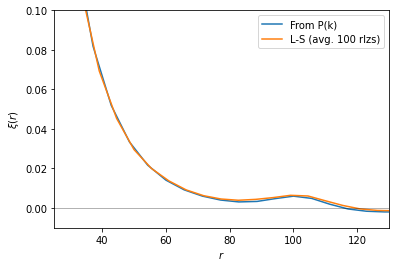

In [13]:
fig, ax = plt.subplots()

ax.plot(rs, xi_arr, label='From P(k)')
ax.plot(r_avg, xi_ls_avg, label=f'L-S (avg. {rlzs} rlzs)')
ax.axhline(0, lw=1, color='k', alpha=0.3)
ax.set_xlabel('$r$')
ax.set_ylabel(r'$\xi(r)$')
ax.set_ylim((-.01,0.1))
ax.set_xlim((25,130))
ax.legend()

So this is the simulation's convention for $P(k) \rightarrow \xi(r)$

Whereas Roman uses the convention without the $1/(2\pi)^3$ prefactor, per Eq. 120 in https://arxiv.org/pdf/astro-ph/0112551.pdf

### predicted variance of $\xi(r)$:

In [14]:
# ** predicted variance in the 2pcf at a certain length scale r
def xi_err_pred(r, V, n, k, Pk):

    # multiplicative constant
    const = 1 / (2*np.pi*V) # (2*np.pi)**5 / V

    # function of k that we want to integrate
    def k_func(k, Pk):
        # return (k/r) * (Pk+(1/n))**2 * (special.jv(1/2, k*r))**2
        return (k/r) * (Pk+(1/n))**2 * (special.jv(1/2, k*r))**2

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([k_func(k, Pk[i]) for i, k in enumerate(k)])
    trapz = integrate.trapz(k_func_arr, x=k)

    return const*trapz

### empirical error in 2pcf

In [15]:
# mock set parameters
L = 750
n = '2e-4'
As = 2
rlzs = 1000
mockset = generate_mock_list.MockSet(L, n, As=As, rlzs=rlzs)

In [16]:
# load in the binned L-S results
mockset.load_xi_lss()
r_avg = mockset.r_avg

In [17]:
# get mean and standard deviation of L-S results
xi_lss = mockset.xi_lss
mean_ls = np.mean(xi_lss, axis=0)
std_ls = np.std(xi_lss, axis=0)

### predicted error in 2pcf

In [18]:
def compute_predicted_xi_err_fixed_n(rs, k, Pk, kmin=None, kmax=None, bias=2.0):
    nbins = len(rs)
    
    # convert from matter power spectrum to galaxy power spectrum
    PkG = bias**2 * Pk

    # optionally, only integrate over part of the input power spectrum in k_func()
    idx = (k>kmin)&(k<kmax)
    k = k[idx]
    PkG = PkG[idx]
    print("after cuts:")
    print(len(k), len(PkG))

    # get predicted variances using xi_err_pred()
    pred_vars = np.empty(nbins)
    for i, r in enumerate(rs):
        pred_vars[i] = xi_err_pred(r, L**3, float(n), k, PkG)

    return pred_vars

In [19]:
# r_avg, k, Pk, kmin, kmax, and bias all defined above
pred_var_fixed_n = compute_predicted_xi_err_fixed_n(r_avg, k, Pk, kmin=kmin, kmax=kmax, bias=b)

after cuts:
389 389


### compare empirical and predicted variances in xi

Text(0.5, 0.98, 'Spread of Landy-Szalay results: L750')

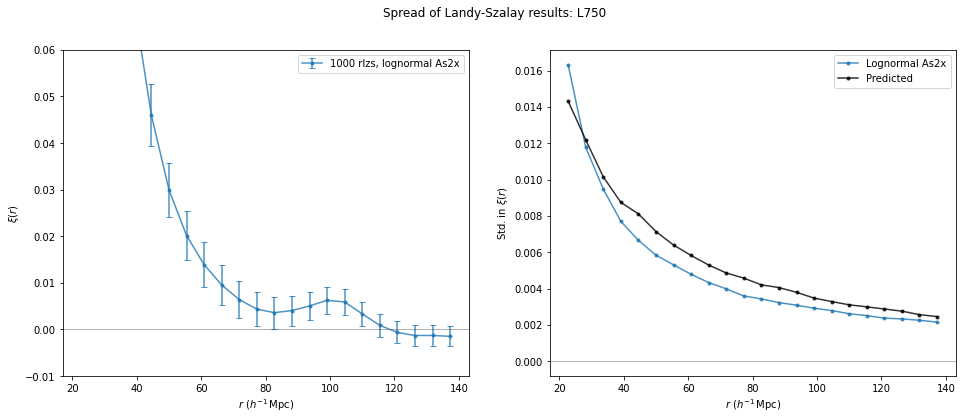

In [20]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(16,6))

ax0.errorbar(r_avg, mean_ls, std_ls, capsize=3, marker='.', alpha=0.8, label='1000 rlzs, lognormal As2x')

ax0.set_ylim((-0.01, 0.06))
ax0.set_ylabel(r"$\xi(r)$")

ax1.plot(r_avg, std_ls, marker='.', alpha=0.8, label='Lognormal As2x')
ax1.plot(r_avg, np.sqrt(pred_var_fixed_n), marker='.', alpha=0.8, color='k', label='Predicted')

# ax1.set_ylim((-0.001, 0.006))
ax1.set_ylabel(r"Std. in $\xi(r)$")

for ax in [ax0, ax1]:
    ax.axhline(0, color='k', alpha=0.3, lw=1)
    ax.set_xlabel(r"$r$ ($h^{-1}\,$Mpc)")
    ax.legend()

fig.suptitle(f"Spread of Landy-Szalay results: L{L}")

### std. vs. number density

In [21]:
def compute_predicted_xi_err_fixed_r(ns, r, k, Pk, kmin=None, kmax=None, bias=2.0):
    
    print(f"computing variance in xi at r = {r:.2f} Mpc/h:")

    # convert from matter power spectrum to galaxy power spectrum
    PkG = bias**2 * Pk

    # optionally, only integrate over part of the input power spectrum in k_func()
    idx = (k>kmin)&(k<kmax)
    k = k[idx]
    PkG = PkG[idx]
    print("after cuts:")
    print(len(k), len(PkG))

    # get predicted variances using xi_err_pred()
    pred_vars = np.empty(len(ns))
    for i, n in enumerate(ns):
        pred_vars[i] = xi_err_pred(r, L**3, float(n), k, PkG)

    return pred_vars

In [22]:
# at three different length scales:
rs = [33.64, 77.27, 131.82]   # corresponds to r bins 2, 10, and 20
ns_fine = np.logspace(-6,-3,50)
pred_vars_fixed_r = [compute_predicted_xi_err_fixed_r(ns_fine, r, k, Pk, kmin=kmin, kmax=kmax) for r in rs]

computing variance in xi at r = 33.64 Mpc/h:
after cuts:
389 389
computing variance in xi at r = 77.27 Mpc/h:
after cuts:
389 389
computing variance in xi at r = 131.82 Mpc/h:
after cuts:
389 389


In [23]:
# parameters for empirical results
L = 750
ns = ['1e-6', '1e-5', '1e-4', '2e-4', '1e-3']
As = 2
rlzs = 1000

In [24]:
r_idxs = [2, 10, 20]
stds = np.empty((len(rs),len(ns)))
for i, n in enumerate(ns):
    mockset = generate_mock_list.MockSet(L, n, As=As, rlzs=rlzs)
    # load in the binned L-S results
    mockset.load_xi_lss()
    # standard deviation
    std_ls = np.std(mockset.xi_lss, axis=0)
    for j, idx in enumerate(r_idxs):
        stds[j,i] = std_ls[idx]

In [25]:
stds

array([[0.35606869, 0.03691704, 0.01081201, 0.00947762, 0.00853558],
       [0.14494561, 0.01705548, 0.00417714, 0.00359207, 0.00328763],
       [0.09670319, 0.01037214, 0.00259059, 0.00225168, 0.00202733]])

Text(0.5, 1.0, 'Std. in 2pcf: L750, lognormal As2x')

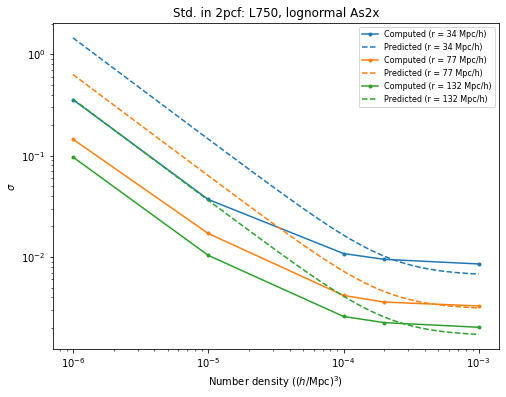

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

cs = ['C0', 'C1', 'C2']
ns = [float(n) for n in ns]
for i, r in enumerate(rs):
    # computed
    ax.plot(ns, stds[i], marker='.', color=cs[i], label=f'Computed (r = {r:.0f} Mpc/h)')
    # predicted
    ax.plot(ns_fine, np.sqrt(pred_vars_fixed_r[i]), color=cs[i], ls='--', label=f'Predicted (r = {r:.0f} Mpc/h)')
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number density ($(h/\mathrm{Mpc})^3$)')
ax.set_ylabel('$\sigma$')
ax.legend(prop={'size':8})
ax.set_title(f'Std. in 2pcf: L{L}, lognormal As{As}x')